# Rossmann Store Sales Forecast
### Forecast sales using store, promotion, and competitor data

The objective is to forecast the "Sales" value for 1115 Rossmann drug stores.

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', lambda x:'%f'%x)

In [3]:
KAGGLE=True
if KAGGLE:
    path="/kaggle/input/rossmann-store-sales/"
else:
    path = "data/"

## What our data looks like

In [4]:
store_details = pd.read_csv(path + "store.csv")
store_details

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9.000000,2008.000000,0,NaN,NaN,NaN
1,2,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000000,9.000000,2009.000000,0,NaN,NaN,NaN
4,5,a,a,29910.000000,4.000000,2015.000000,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.000000,6.000000,2014.000000,1,31.000000,2013.000000,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.000000,4.000000,2006.000000,0,NaN,NaN,NaN
1112,1113,a,c,9260.000000,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.000000,NaN,NaN,0,NaN,NaN,NaN


Store Data fields
* Store - a unique Id for each store
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [5]:
# Our Train data
train_data = pd.read_csv(path + "train.csv")
train_data

/tmp/ipykernel_13/1541405201.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(path + "train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
# Our Train data
test_data = pd.read_csv(path + "test.csv")
test_data

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.000000,1,0,0
1,2,3,4,2015-09-17,1.000000,1,0,0
2,3,7,4,2015-09-17,1.000000,1,0,0
3,4,8,4,2015-09-17,1.000000,1,0,0
4,5,9,4,2015-09-17,1.000000,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.000000,0,0,0
41084,41085,1112,6,2015-08-01,1.000000,0,0,0
41085,41086,1113,6,2015-08-01,1.000000,0,0,0
41086,41087,1114,6,2015-08-01,1.000000,0,0,0


Train Data fields
* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* Promo - indicates whether a store is running a promo on that day

In [7]:
# merged our train data and store details data based on store number to get complete info for each store
combined_data = pd.merge(train_data, store_details, on='Store')
combined_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000000,9.000000,2008.000000,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000000,9.000000,2009.000000,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.000000,4.000000,2015.000000,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.000000,6.000000,2014.000000,1,31.000000,2013.000000,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.000000,4.000000,2006.000000,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.000000,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.000000,NaN,NaN,0,NaN,NaN,NaN


In [8]:
combined_data.shape

(1017209, 18)

## EDA

In [9]:
# missing values in the dataset
print("Total size of dataset: ", len(combined_data))
print(combined_data.isnull().sum())

Total size of dataset:  1017209
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


In [10]:
# unique values in dataset
columns = list(combined_data.columns)
columns.remove('Date')
columns.remove('CompetitionDistance')
for col in columns:
    print(col,"-------->",combined_data[col].unique())

Store --------> [   1    2    3 ... 1113 1114 1115]
DayOfWeek --------> [5 4 3 2 1 7 6]
Sales --------> [ 5263  6064  8314 ...   660 17815 23303]
Customers --------> [ 555  625  821 ... 3900   36 4065]
Open --------> [1 0]
Promo --------> [1 0]
StateHoliday --------> ['0' 'a' 'b' 'c' 0]
SchoolHoliday --------> [1 0]
StoreType --------> ['c' 'a' 'd' 'b']
Assortment --------> ['a' 'c' 'b']
CompetitionOpenSinceMonth --------> [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
CompetitionOpenSinceYear --------> [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Promo2 --------> [0 1]
Promo2SinceWeek --------> [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Promo2SinceYear --------> [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
PromoInterval --------> [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


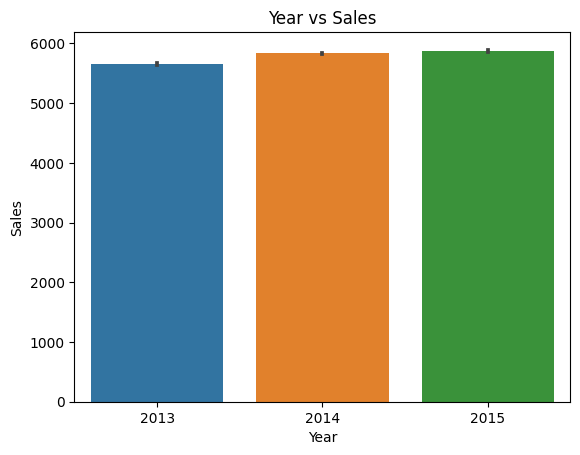

CPU times: user 12.6 s, sys: 22.9 ms, total: 12.6 s
Wall time: 12.7 s


In [11]:
%%time
# extracting year and month from Date 
# combined_data['Year']  = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
# combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))

combined_data['Year']  = pd.to_datetime(combined_data['Date']).dt.year
combined_data['Month']  = pd.to_datetime(combined_data['Date']).dt.month

# Sales with respect to year 
sns.barplot(x='Year', y='Sales', data=combined_data).set(title='Year vs Sales')
plt.show()

##### Sales have been increasing year to year

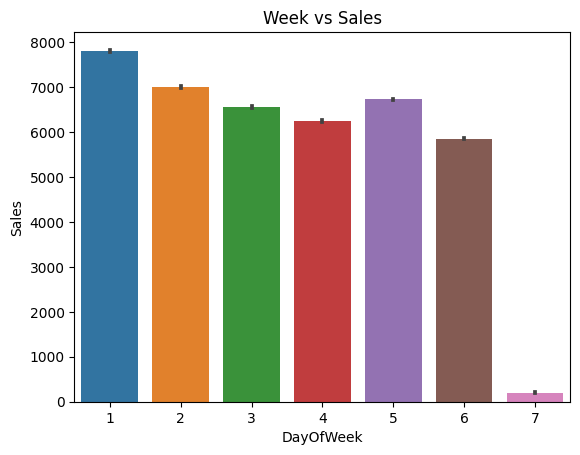

In [12]:
# Sales with respect to week
sns.barplot(x='DayOfWeek', y='Sales', data=combined_data).set(title='Week vs Sales')
plt.show()

##### Sales on 1 (Monday) and 5 (Friday) are the highest

[Text(0.5, 1.0, 'Promo vs Sales')]

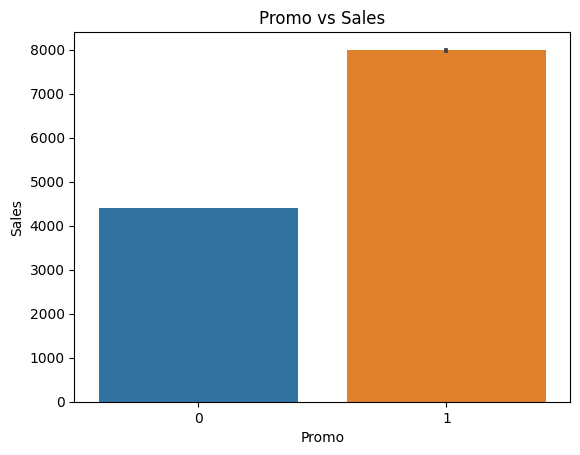

In [13]:
# Sales with respect to Promo
sns.barplot(x='Promo', y='Sales', data=combined_data).set(title='Promo vs Sales')
# plt.show()

##### Customers are definately attracted by Promo codes thus sales are higher when there is a Promo code in a Store

CPU times: user 14.8 s, sys: 26.5 ms, total: 14.9 s
Wall time: 14.9 s


[Text(0.5, 1.0, 'State Holiday vs Sales')]

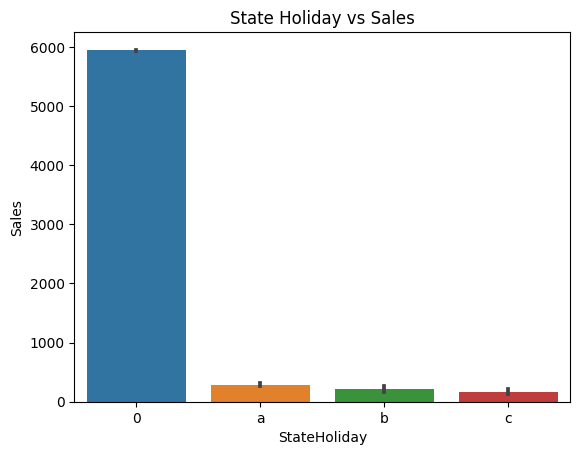

In [14]:
%%time
# StateHoliday column has values 0 & "0", So, we need to change values with 0 to "0"
# combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == 0] = "0"
combined_data.loc[combined_data["StateHoliday"] == 0,"StateHoliday"] = "0"

# Sales with respect to State Holiday
sns.barplot(x='StateHoliday', y='Sales', data=combined_data).set(title='State Holiday vs Sales')
# plt.show()

[Text(0.5, 1.0, 'State Holiday vs Sales')]

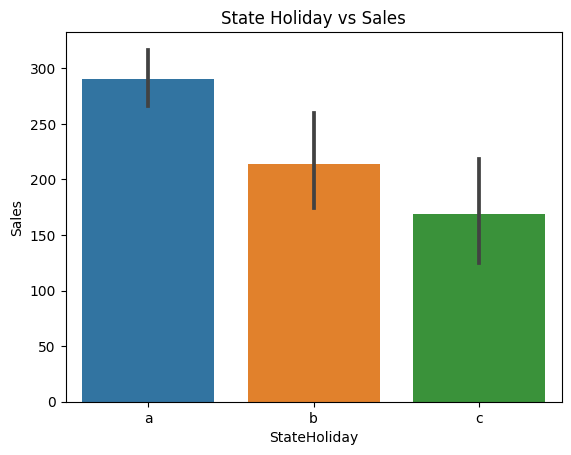

In [15]:
mask=combined_data["StateHoliday"]!="0"
sns.barplot(x='StateHoliday', y='Sales', data=combined_data[mask]).set(title='State Holiday vs Sales')

##### Most stores are closed on State Holidays that's why we can see that there are very less sales in a,b,c where:
* a = Public Holiday
* b = Easter Holiday
* c = Chirstmas 
* 0 = No Holiday, Working day

[Text(0.5, 1.0, 'School Holiday vs Sales')]

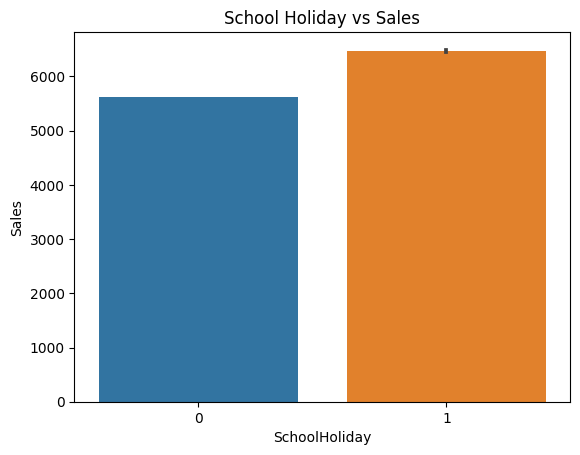

In [16]:
# Sales with respect to School Holiday
sns.barplot(x='SchoolHoliday', y='Sales', data=combined_data).set(title='School Holiday vs Sales')
# plt.show()

##### On School Holidays there are more sales!

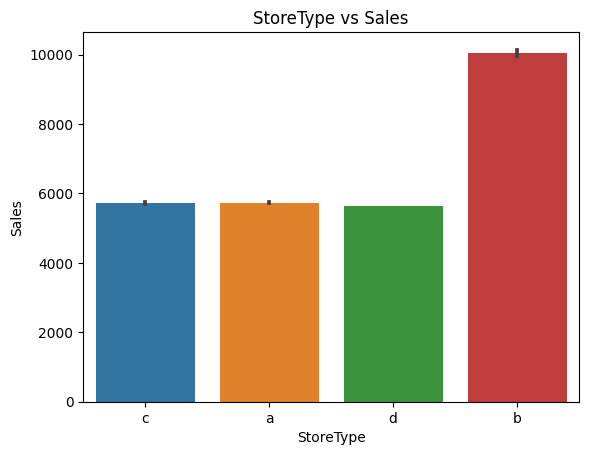

In [17]:
# Sales with respect to StoreType
sns.barplot(x='StoreType', y='Sales', data=combined_data).set(title='StoreType vs Sales')
plt.show()

[Text(0.5, 1.0, 'StoreType vs Sales')]

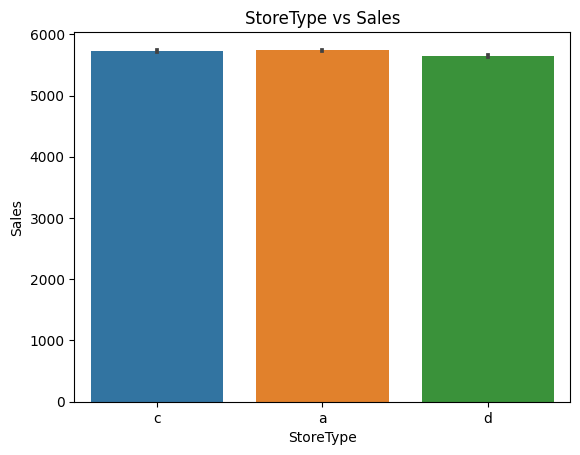

In [18]:
mask=combined_data["StoreType"]!="b"
sns.barplot(x='StoreType', y='Sales', data=combined_data[mask]).set(title='StoreType vs Sales')

##### a,b,c,d are store models where b type stores have the highest sales 

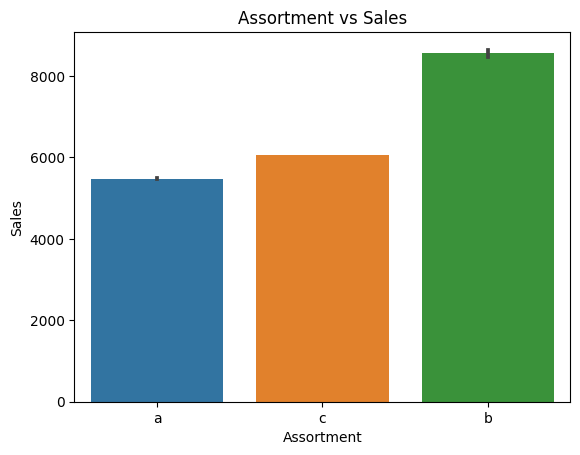

In [19]:
# Sales with respect to Assortment
sns.barplot(x='Assortment', y='Sales', data=combined_data).set(title='Assortment vs Sales')
plt.show()

##### Assortment level b have the highest sales
##### Assortment levels:
* a = basic
* b = extra
* c = entended

## Filling Missing Values and Removing Outliers

Few columns have high number of missing values, so we need to fill them with appropriate method for better result

### Filling Missing Values
##### Approach
1: The null values in Column Promo2SinceWeek, Promo2SinceYear, PromoInterval is due to Promo2 is 0 for those stores. So we would fill all the null values in these columns with 0.

2: Since Competition Distance for 3 stores isn't given so we could fill it with mean of the distance given for all other stores

3: CompetitionOpenSinceMonth, CompetitionOpenSinceYear can be filled using the most occuring month and year respectively. 

In [20]:
store_details.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [21]:
mask= store_details["Promo2"]==0
print(len(store_details[mask]))

544


In [22]:
train_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [23]:
# Filling Promo2SinceWeek, Promo2SinceYear, PromoInterval with 0
store_details.update(store_details[['Promo2SinceWeek','Promo2SinceYear','PromoInterval']].fillna(0))

In [24]:
# Filling CompetitionDistance with mean distance
mean_competition_distance = store_details['CompetitionDistance'].mean()
# store_details['CompetitionDistance'].fillna(mean_competition_distance, inplace=True)
store_details['CompetitionDistance']=store_details['CompetitionDistance'].fillna(mean_competition_distance)

In [25]:
# Filling CompetitionOpenSinceMonth, CompetitionOpenSinceYear with most occuring month and year respectively
mode_competition_open_month = store_details['CompetitionOpenSinceMonth'].mode()[0]

mode_competition_open_year = store_details['CompetitionOpenSinceYear'].mode()[0]

# store_details['CompetitionOpenSinceMonth'].fillna(mode_competition_open_month,inplace=True)
# store_details['CompetitionOpenSinceYear'].fillna(mode_competition_open_year,inplace=True)

store_details['CompetitionOpenSinceMonth']=store_details['CompetitionOpenSinceMonth'].fillna(mode_competition_open_month)
store_details['CompetitionOpenSinceYear']=store_details['CompetitionOpenSinceYear'].fillna(mode_competition_open_year)

In [26]:
store_details.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

* All missing values have been filled

In [27]:
# merging the data again
combined_data = pd.merge(train_data, store_details, on='Store')
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000000,9.000000,2008.000000,0,0.000000,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000000,9.000000,2009.000000,0,0.000000,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.000000,4.000000,2015.000000,0,0.000000,0.000000,0


In [28]:
combined_data.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [29]:
combined_data.loc[combined_data["StateHoliday"] == 0,"StateHoliday"] = "0"

<Axes: title={'center': 'Sales vs CompetitionDistance'}, xlabel='CompetitionDistance', ylabel='Sales'>

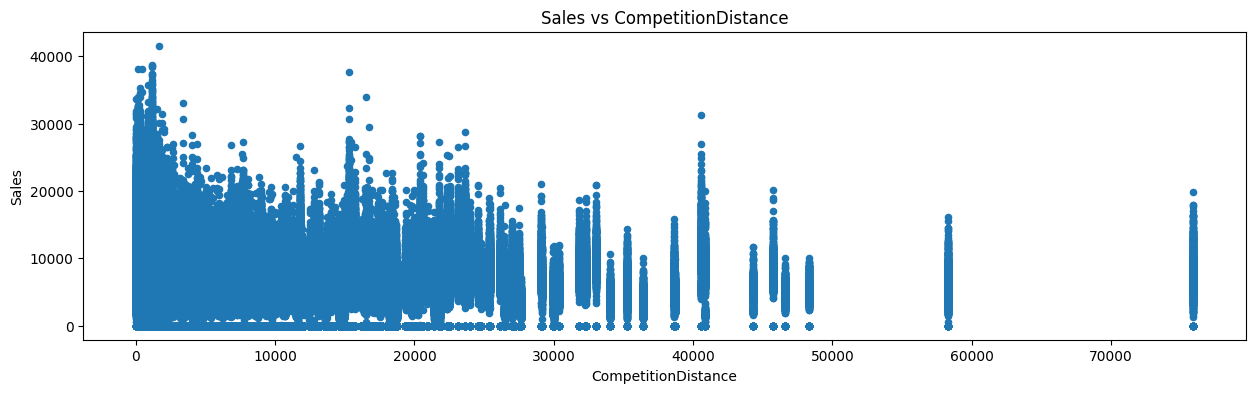

In [30]:
combined_data.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4),title="Sales vs CompetitionDistance")

* CompetitionDistance is the distance in meters to the nearest competitor store, the more nearer the two stores are the more sales can be seen

### Finding Outliers

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


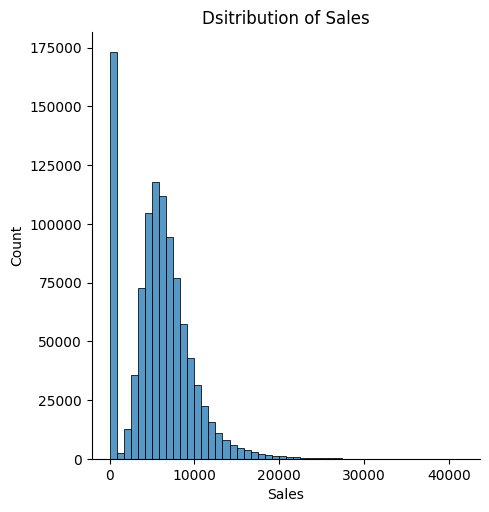

In [31]:
# checking distribution of sales 
sns.displot(combined_data, x="Sales",bins=50).set(title='Dsitribution of Sales')

* As we can see in the distribution plot Sales greater than 30k are very less so they might be the outliers

Total outlier in dataset are:  30769
Minimum Sales Outlier:  13611.5
Maximum Sales Outlier:  41551


<Axes: xlabel='Sales'>

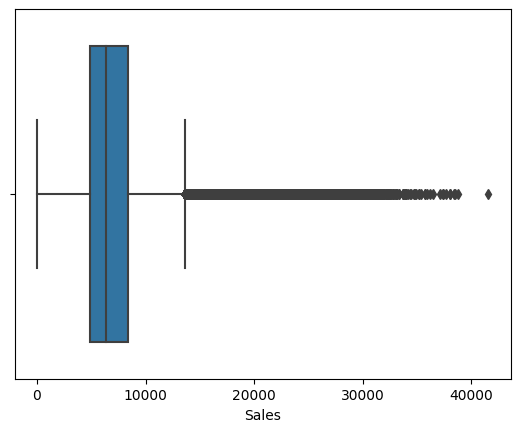

In [32]:
mask=combined_data["Sales"]!=0
combined_filt = combined_data["Sales"][mask]
# combined_filt = combined_data["Sales"].copy()
q1 = np.nanpercentile(combined_filt, 25)
q3 = np.nanpercentile(combined_filt, 75)
iqr = q3-q1

outlier_min = q3 + 1.5 * iqr
outlier_max = combined_filt.max()

outlier_size = len(combined_filt[(combined_filt >=outlier_min) & (combined_filt<=outlier_max)])

print('Total outlier in dataset are: ', outlier_size)
print("Minimum Sales Outlier: ", outlier_min)
print("Maximum Sales Outlier: ",outlier_max)

sns.boxplot(x=combined_filt)

### Z-Score: If the Z-Score of a datapoint is greater than 3 that can be considered as an Outlier

Mean of Sales:  5773.818972305593
Standard Deviation of Sales:  3849.924282844153
Total outlier in dataset are:  9731
Maximum Sales Outlier:  41551
Minimum Sales Outlier:  17325
CPU times: user 133 ms, sys: 3.06 ms, total: 136 ms
Wall time: 128 ms


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


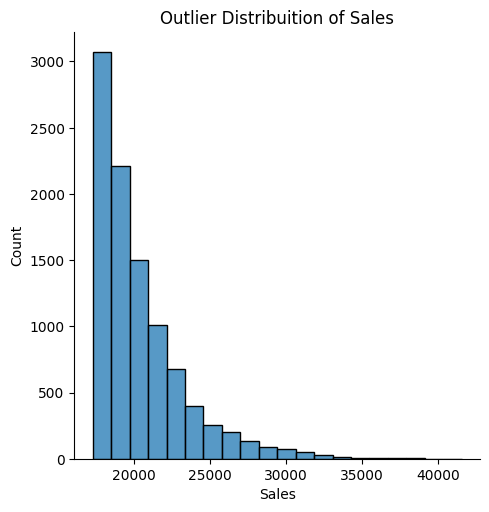

In [33]:
%%time
# mask=combined_data["Sales"]!=0
# combined_filt = combined_data["Sales"][mask]
combined_filt = combined_data["Sales"].copy()

mean_of_sales = np.mean(combined_filt) 
std_of_sales = np.std(combined_filt)

threshold = 3

z_score = (combined_filt - mean_of_sales) / std_of_sales
outlier = combined_filt[z_score > threshold]

print("Mean of Sales: ",mean_of_sales)
print("Standard Deviation of Sales: ",std_of_sales)

print('Total outlier in dataset are: ', len(outlier))
print("Maximum Sales Outlier: ", outlier.max())
print("Minimum Sales Outlier: ", outlier.min())

sns.displot(x=outlier,bins=20).set(title='Outlier Distribuition of Sales')

In [34]:
# Looking for outliers
sales_zero = combined_data.loc[combined_data['Sales'] == 0] 
sales_greater_than_30 = combined_data.loc[combined_data['Sales'] > 30000]

print("Length of actual dataset:", len(combined_data))
print("Length of data where sales is 0:", len(sales_zero),
      " which is", len(sales_zero)/len(combined_data)*100, "% of the whole data", )

print("Length of data which is greater than 30:", len(sales_greater_than_30),
      "which is ", len(sales_greater_than_30)/len(combined_data)*100, "% of the whole data")

Length of actual dataset: 1017209
Length of data where sales is 0: 172871  which is 16.994639253093514 % of the whole data
Length of data which is greater than 30: 153 which is  0.015041156733768577 % of the whole data


* Droping sales which are greater than 30k as they are very less in the dataset and are probably outliers

In [35]:
combined_data.drop(combined_data.loc[combined_data['Sales'] > 30000].index,inplace=True)
combined_data.shape

(1017056, 18)

## Further EDA - exploring exceptional cases
Looking for a scenerio where the Stores are open and yet there is no sales on that day

In [36]:
# no sales when Stores were Open
combined_data_filt = combined_data[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1)]
# combined_data_filt = combined_data.copy()
no_holiday_zero_sales = combined_data_filt

print("Size of the data where sales were zero even when stores were open: ",len(no_holiday_zero_sales))
no_holiday_zero_sales.head()

Size of the data where sales were zero even when stores were open:  54


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
86825,971,5,2015-05-15,0,0,1,0,0,1,c,a,1140.000000,5.000000,2011.000000,1,14.000000,2012.000000,"Mar,Jun,Sept,Dec"
142278,674,4,2015-03-26,0,0,1,0,0,0,a,a,2640.000000,12.000000,2005.000000,1,31.000000,2013.000000,"Feb,May,Aug,Nov"
196938,699,4,2015-02-05,0,0,1,1,0,0,a,a,180.000000,9.000000,2013.000000,1,5.000000,2013.000000,"Jan,Apr,Jul,Oct"
322053,708,3,2014-10-01,0,0,1,1,0,0,c,c,11470.000000,10.000000,2009.000000,1,18.000000,2014.000000,"Jan,Apr,Jul,Oct"
330176,357,1,2014-09-22,0,0,1,0,0,0,a,a,2060.000000,10.000000,2008.000000,0,0.000000,0.000000,0


In [37]:
# no sales when Stores were Open
no_holiday_zero_sales = combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) & 
                                          (combined_data['StateHoliday'] == "0") & (combined_data['SchoolHoliday'] == 0)]

print("Size of the data where sales were zero even when stores were open: ",len(no_holiday_zero_sales))
no_holiday_zero_sales.head()

Size of the data where sales were zero even when stores were open:  42


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
142278,674,4,2015-03-26,0,0,1,0,0,0,a,a,2640.000000,12.000000,2005.000000,1,31.000000,2013.000000,"Feb,May,Aug,Nov"
196938,699,4,2015-02-05,0,0,1,1,0,0,a,a,180.000000,9.000000,2013.000000,1,5.000000,2013.000000,"Jan,Apr,Jul,Oct"
322053,708,3,2014-10-01,0,0,1,1,0,0,c,c,11470.000000,10.000000,2009.000000,1,18.000000,2014.000000,"Jan,Apr,Jul,Oct"
330176,357,1,2014-09-22,0,0,1,0,0,0,a,a,2060.000000,10.000000,2008.000000,0,0.000000,0.000000,0
340348,227,4,2014-09-11,0,0,1,0,0,0,a,a,2370.000000,9.000000,2013.000000,0,0.000000,0.000000,0


* Removing these data points too as they are an exceptional case

In [38]:
combined_data.drop(combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) & 
                                     (combined_data['StateHoliday'] == "0") & 
                                     (combined_data['SchoolHoliday'] == 0)].index,inplace=True)
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000000,9.000000,2008.000000,0,0.000000,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000000,9.000000,2009.000000,0,0.000000,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.000000,4.000000,2015.000000,0,0.000000,0.000000,0


## Converting Categorical Variable to Numeric

In [39]:
# extracting year and month from Date 
# combined_data['Year']  = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
# combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))

combined_data["Date"] = pd.to_datetime(combined_data["Date"])
combined_data['Year']  = combined_data['Date'].dt.year
combined_data['Month'] = combined_data['Date'].dt.month
combined_data = combined_data.sort_values(['Date'],ascending = False)

# combined_data.drop(['Date'],axis=1,inplace=True)

In [40]:
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000000,9.000000,2008.000000,0,0.000000,0.000000,0,2015,7
742,743,5,2015-07-31,5085,501,1,1,0,1,a,a,6710.000000,11.000000,2003.000000,1,14.000000,2012.000000,"Jan,Apr,Jul,Oct",2015,7
748,749,5,2015-07-31,6612,716,1,1,0,1,a,a,3410.000000,8.000000,2011.000000,1,14.000000,2015.000000,"Jan,Apr,Jul,Oct",2015,7
747,748,5,2015-07-31,7481,578,1,1,0,1,d,a,2380.000000,3.000000,2010.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct",2015,7
746,747,5,2015-07-31,10708,826,1,1,0,1,c,c,45740.000000,8.000000,2008.000000,0,0.000000,0.000000,0,2015,7


In [41]:
# encoding all categorical varibale to numeric values
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

combined_data['StoreType']= label_encoder.fit_transform(combined_data['StoreType'])
combined_data['Assortment']= label_encoder.fit_transform(combined_data['Assortment']) 

# for promo interval
combined_data.loc[combined_data["PromoInterval"] == "Jan,Apr,Jul,Oct","PromoInterval"] = 1
combined_data.loc[combined_data["PromoInterval"] == "Feb,May,Aug,Nov","PromoInterval"] = 2
combined_data.loc[combined_data["PromoInterval"] == "Mar,Jun,Sept,Dec","PromoInterval"] = 3


# for State Holiday
combined_data.loc[combined_data["StateHoliday"] == "a","StateHoliday"] = 1
combined_data.loc[combined_data["StateHoliday"] == "b","StateHoliday"] = 2
combined_data.loc[combined_data["StateHoliday"] == "c","StateHoliday"] = 3

combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,2,0,1270.000000,9.000000,2008.000000,0,0.000000,0.000000,0,2015,7
742,743,5,2015-07-31,5085,501,1,1,0,1,0,0,6710.000000,11.000000,2003.000000,1,14.000000,2012.000000,1,2015,7
748,749,5,2015-07-31,6612,716,1,1,0,1,0,0,3410.000000,8.000000,2011.000000,1,14.000000,2015.000000,1,2015,7
747,748,5,2015-07-31,7481,578,1,1,0,1,3,0,2380.000000,3.000000,2010.000000,1,14.000000,2011.000000,1,2015,7
746,747,5,2015-07-31,10708,826,1,1,0,1,2,2,45740.000000,8.000000,2008.000000,0,0.000000,0.000000,0,2015,7


In [42]:
combined_data['StateHoliday'] = pd.to_numeric(combined_data['StateHoliday'])
combined_data['PromoInterval'] = pd.to_numeric(combined_data['PromoInterval'])

<Axes: >

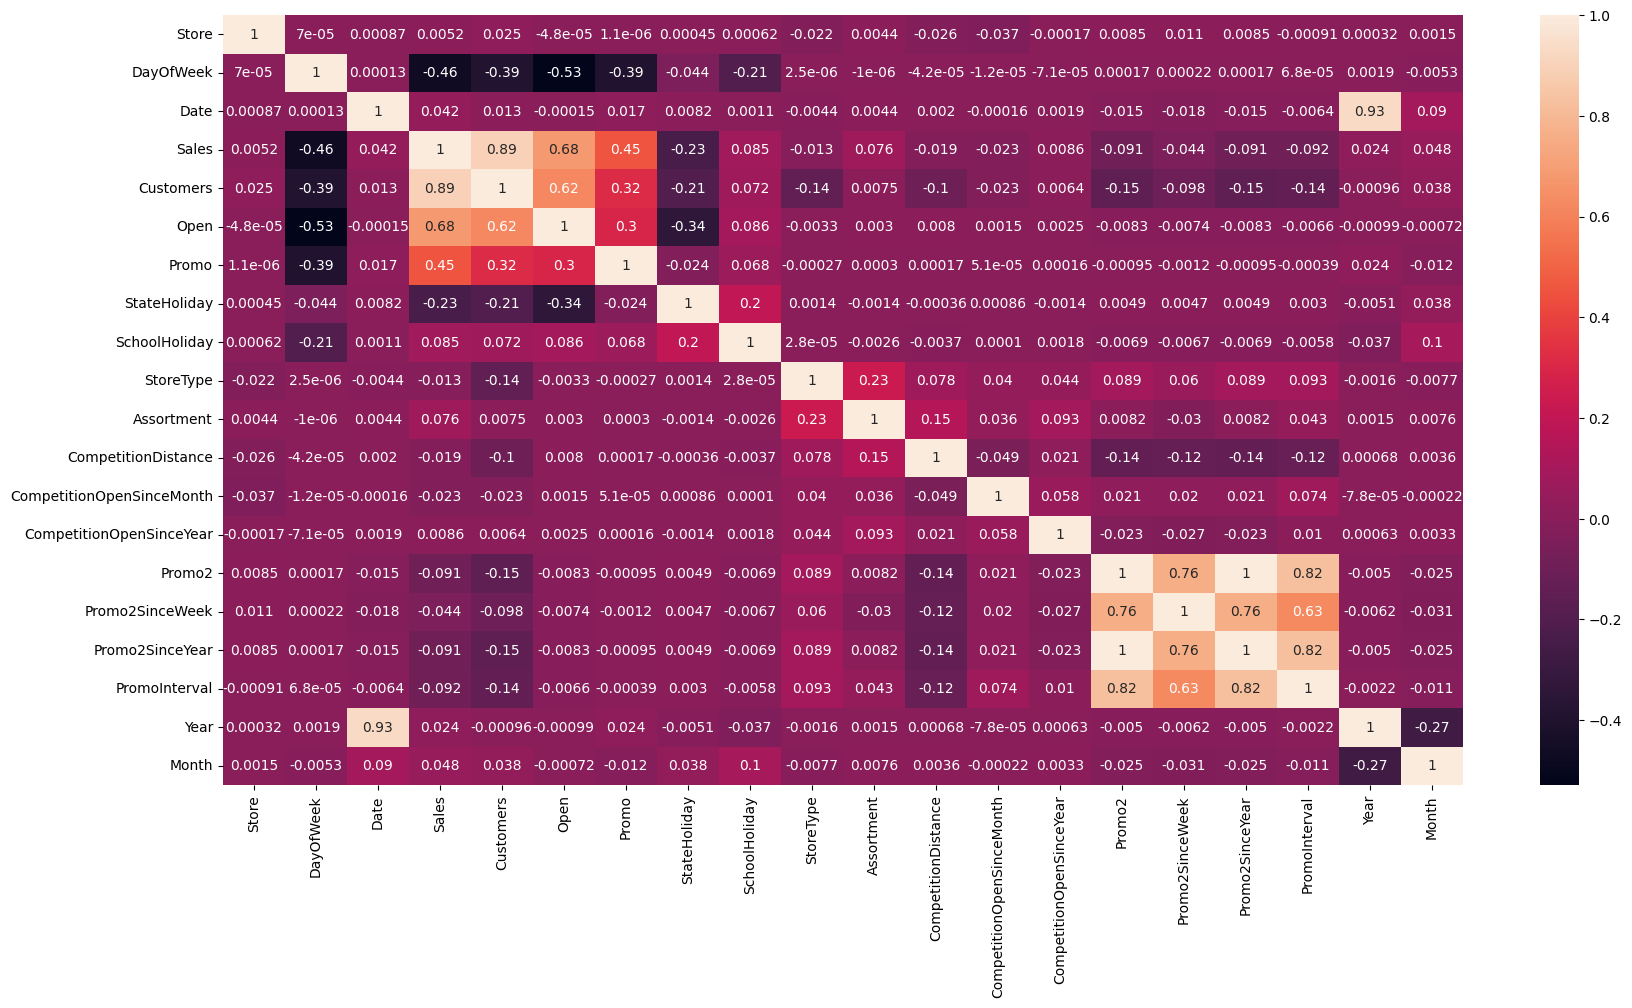

In [43]:
plt.figure(figsize=(20,10))
sns.heatmap(combined_data.corr(),annot=True)

##### Correlation map shows
* Sales is highly correlated with Customers, Open, Promo code
* Promo code is highly correlated to Promo2SinceWeek, Promo2SinceYear, PromoInterval

## Test Data Preprocessing

In [44]:
print(test_data["Open"].unique())
print(test_data.isnull().sum())
test_data['Open']=test_data['Open'].fillna(1)
test = pd.merge(test_data, store_details, on='Store')

[ 1. nan  0.]
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64


In [45]:
test.loc[test["StateHoliday"] == 0,"StateHoliday"] = "0"

# test['Year']  = test['Date'].apply(lambda x: int(str(x)[:4]))
# test['Month'] = test['Date'].apply(lambda x: int(str(x)[5:7]))

test['Date']  = pd.to_datetime(test['Date'])
test['Year']  = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
# encoding all categorical varibale to numeric values
label_encoder = preprocessing.LabelEncoder()

test['StoreType']= label_encoder.fit_transform(test['StoreType'])
test['Assortment']= label_encoder.fit_transform(test['Assortment']) 

# for promo interval
test.loc[test["PromoInterval"] == "Jan,Apr,Jul,Oct","PromoInterval"] = 1
test.loc[test["PromoInterval"] == "Feb,May,Aug,Nov","PromoInterval"] = 2
test.loc[test["PromoInterval"] == "Mar,Jun,Sept,Dec","PromoInterval"] = 3


# for State Holiday
test.loc[test["StateHoliday"] == "a","StateHoliday"] = 1
test.loc[test["StateHoliday"] == "b","StateHoliday"] = 2
test.loc[test["StateHoliday"] == "c","StateHoliday"] = 3

In [46]:
test['StateHoliday'] = pd.to_numeric(test['StateHoliday'])
test['PromoInterval'] = pd.to_numeric(test['PromoInterval'])

## Implementing Models

In [47]:
combined_data[combined_data['Open']==0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
875,876,5,2015-07-31,0,0,0,1,0,1,0,0,21790.000000,4.000000,2005.000000,1,18.000000,2015.000000,2,2015,7
291,292,5,2015-07-31,0,0,0,1,0,1,0,0,1100.000000,6.000000,2009.000000,0,0.000000,0.000000,0,2015,7
1990,876,4,2015-07-30,0,0,0,1,0,1,0,0,21790.000000,4.000000,2005.000000,1,18.000000,2015.000000,2,2015,7
1406,292,4,2015-07-30,0,0,0,1,0,1,0,0,1100.000000,6.000000,2009.000000,0,0.000000,0.000000,0,2015,7
3105,876,3,2015-07-29,0,0,0,1,0,1,0,0,21790.000000,4.000000,2005.000000,1,18.000000,2015.000000,2,2015,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016471,377,2,2013-01-01,0,0,0,0,1,1,0,2,100.000000,6.000000,2010.000000,1,18.000000,2010.000000,2,2013,1
1016472,378,2,2013-01-01,0,0,0,0,1,1,0,2,2140.000000,8.000000,2012.000000,0,0.000000,0.000000,0,2013,1
1016473,379,2,2013-01-01,0,0,0,0,1,1,3,0,6630.000000,9.000000,2013.000000,0,0.000000,0.000000,0,2013,1
1016474,380,2,2013-01-01,0,0,0,0,1,1,0,0,2240.000000,5.000000,2013.000000,1,10.000000,2014.000000,3,2013,1


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math  

In [49]:
# mask = (combined_data['Open'] == 1)
mask = (combined_data['Open'] == 1) & (combined_data['Sales'] !=0)
combined_data_subset = combined_data[mask]
combined_data_subset_closed = combined_data[combined_data['Open'] == 0]
# x_train, x_test, y_train, y_test_open = train_test_split(combined_data_subset.drop(['Sales','Customers', 'Open'],axis=1),
#                                                     combined_data_subset['Sales'],test_size=0.20)


train_rows = combined_data_subset[6*7*1115:]
test_rows = combined_data_subset[:6*7*1115]

# x_train = train_rows.drop(['Sales','Customers', 'Open'],axis=1)
x_train = train_rows.drop(['Sales','Customers', 'Open','Date'],axis=1)
y_train = train_rows.Sales
# x_test = test_rows.drop(['Sales','Customers', 'Open'],axis=1)
x_test = test_rows.drop(['Sales','Customers', 'Open','Date'],axis=1)
y_test_open = test_rows.Sales

In [50]:
combined_data_subset.shape,x_train.shape,x_test.shape

((844185, 20), (797355, 16), (46830, 16))

In [51]:
epsilon = 1e-10

In [52]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month'],
      dtype='object')

In [53]:
print(test.columns)
test_ids = test["Id"].to_numpy()
# test = test.drop(["Id","Open"],axis=1)
test = test.drop(["Id","Date","Open"],axis=1)

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month'],
      dtype='object')


In [54]:
from statsmodels.tools.eval_measures import rmspe

In [55]:
# def rmspe_score(y, yhat):
#     return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_score(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / (y_true+epsilon))), axis=0))

    return loss

## Linear Regression

In [56]:
%%time
from sklearn import linear_model

gaussian_noise = np.random.normal(loc=0, scale=1, size=1)

reg_model = linear_model.LinearRegression() # making regression model
reg_model.fit(x_train, y_train) 

prediction_open = reg_model.predict(x_test)

prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("Test Open Root mean squared error: ", math.sqrt(mean_squared_error(y_test_open,prediction_open)))
print("----------------------------------------------------------")
print("Test Open RMSPE: ", rmspe_score(y_test_open,prediction_open))
print("----------------------------------------------------------")
prediction_train = reg_model.predict(x_train)
print("Train Root mean squared error: ", math.sqrt(mean_squared_error(y_train,prediction_train)))
print("Train  RMSPE: ", rmspe_score(y_train,prediction_train))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))
print("RMSPE: ", rmspe_score(y_test,prediction))


Test Open Root mean squared error:  2711.1418943133413
----------------------------------------------------------
Test Open RMSPE:  0.4944127794303255
----------------------------------------------------------
Train Root mean squared error:  2774.037920553653
Train  RMSPE:  0.5214467070349651
r2_score:  0.850917354140998
Mean absolute error: 429.54
Root mean squared error:  1251.8482569808334
RMSPE:  0.2282911777716675
CPU times: user 1.42 s, sys: 275 ms, total: 1.7 s
Wall time: 1.12 s


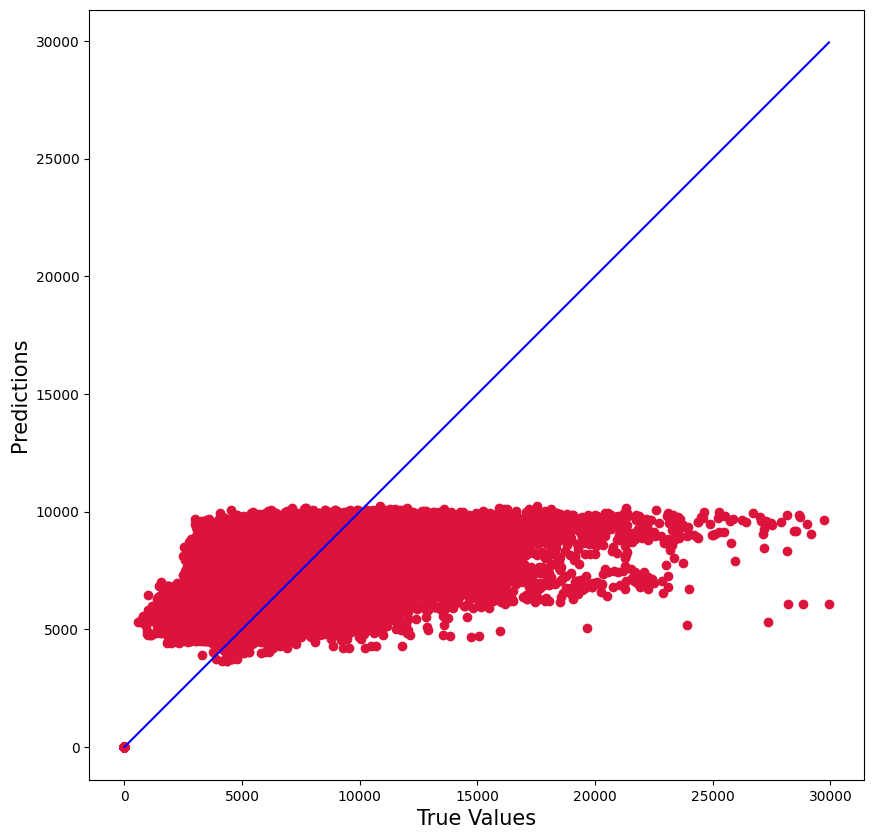

In [57]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Random Forest Regressor

Test Open Root mean squared error:  978.1139442841411
----------------------------------------------------------
Test Open RMSPE:  0.13470632686569267
----------------------------------------------------------
Train Root mean squared error:  994.8313138900877
Train  RMSPE:  0.21007757574862812
r2_score:  0.9805955429004816
Mean absolute error: 145.03
Root mean squared error:  451.63635250853235
RMSPE:  0.06219957754509846


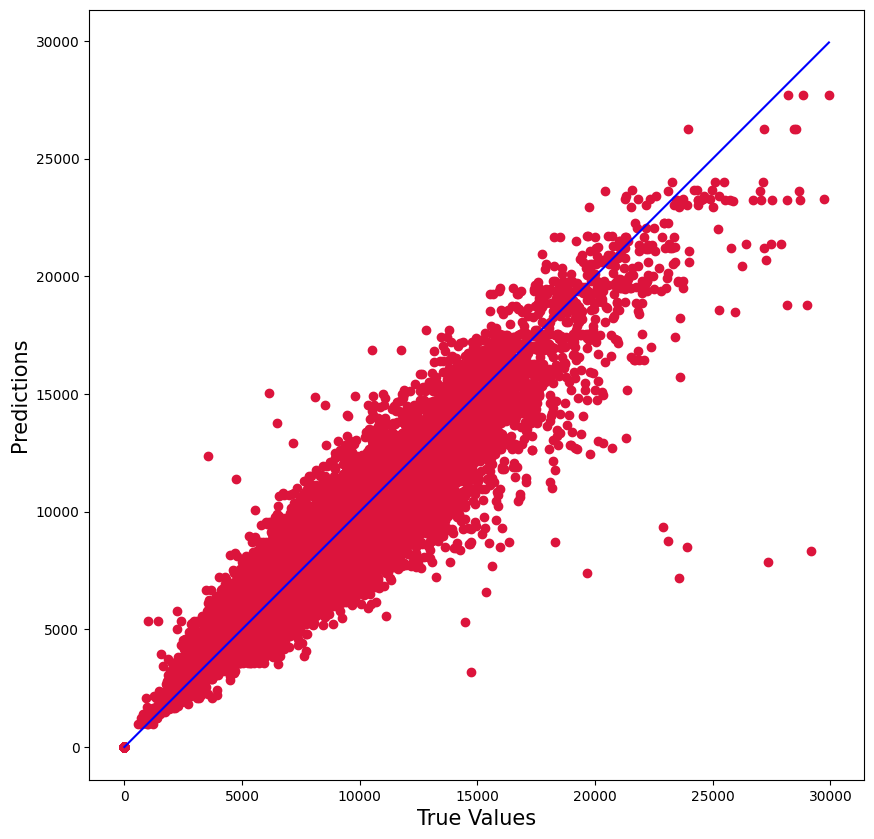

CPU times: user 2min, sys: 451 ms, total: 2min 1s
Wall time: 33.3 s


In [58]:
%%time
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor_model = RandomForestRegressor(n_estimators=25,
                                                      min_samples_split=50,max_features=0.9,
                                                      n_jobs=-1)
random_forest_regressor_model.fit(x_train,y_train)

prediction_open = random_forest_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("Test Open Root mean squared error: ", math.sqrt(mean_squared_error(y_test_open,prediction_open)))
print("----------------------------------------------------------")
print("Test Open RMSPE: ", rmspe_score(y_test_open,prediction_open))
print("----------------------------------------------------------")
prediction_train = random_forest_regressor_model.predict(x_train)
print("Train Root mean squared error: ", math.sqrt(mean_squared_error(y_train,prediction_train)))
print("Train  RMSPE: ", rmspe_score(y_train,prediction_train))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))
print("RMSPE: ", rmspe_score(y_test,prediction))

plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Understanding Random Forest important features

In [59]:
# getting weights of all the features used in the data
feature_importance = random_forest_regressor_model.feature_importances_
columns = list(x_train.columns)
feature_importance_value = []
for i in range(len(feature_importance)):
    feature_importance_value.append(round(feature_importance[i],5))
# making a dataframe
feature_importance_df = pd.DataFrame({"Features":columns,
                                     "Values":feature_importance_value })
feature_importance_df.sort_values(by=["Values"], inplace=True, ascending=False)
feature_importance_df

,Features,Values
7,CompetitionDistance,0.219780
0,Store,0.186210
2,Promo,0.151740
9,CompetitionOpenSinceYear,0.083630
8,CompetitionOpenSinceMonth,0.074860
1,DayOfWeek,0.072630
5,StoreType,0.037460
15,Month,0.036550
12,Promo2SinceYear,0.033650
6,Assortment,0.033570


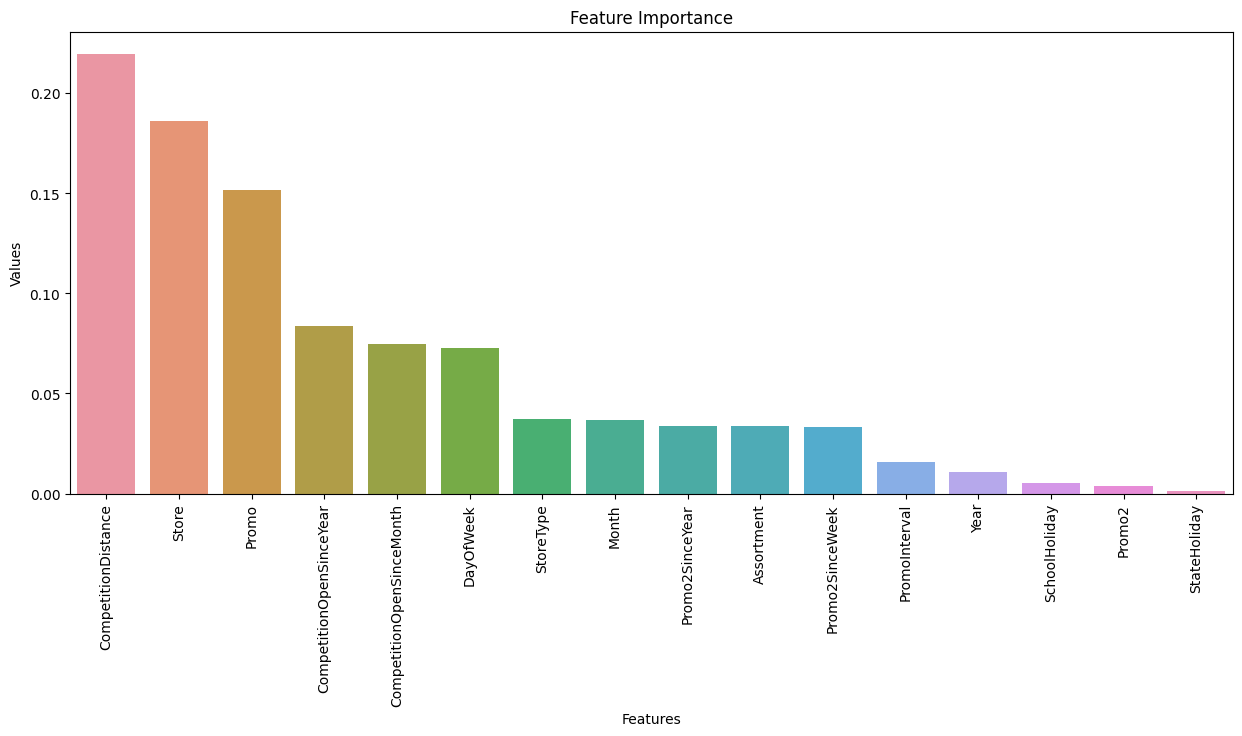

In [60]:
# Feature Importance
plt.figure(figsize=(15,6))

sns.barplot(x=feature_importance_df['Features'], y=feature_importance_df['Values'],
            data = feature_importance_df ).set(title='Feature Importance')

plt.xticks(rotation=90)
plt.show()

Feature Importance conclusion
* Feature engineering is very important. e.g. removal of the 'Open'. feature
* Closer competiton distance make stores more competitive and thus using Promo codes can help them to boost sales 
* Store Type affects the sales
* Promo code can help increase in the competition and lead to more sales
* Since most of the stores are closed on Holidays, the feature has no effect on sales

## Decision Tree Regressor

Test Open Root mean squared error:  1298.3549155287783
----------------------------------------------------------
Test Open RMSPE:  0.17862558098361922
----------------------------------------------------------
Train Root mean squared error:  635.9363595749193
Train  Root RMSPE:  0.1549701650659184
r2_score:  0.9658091853440302
Mean absolute error: 184.14
Root mean squared error:  599.5050798913843
RMSPE:  0.08247894463788934


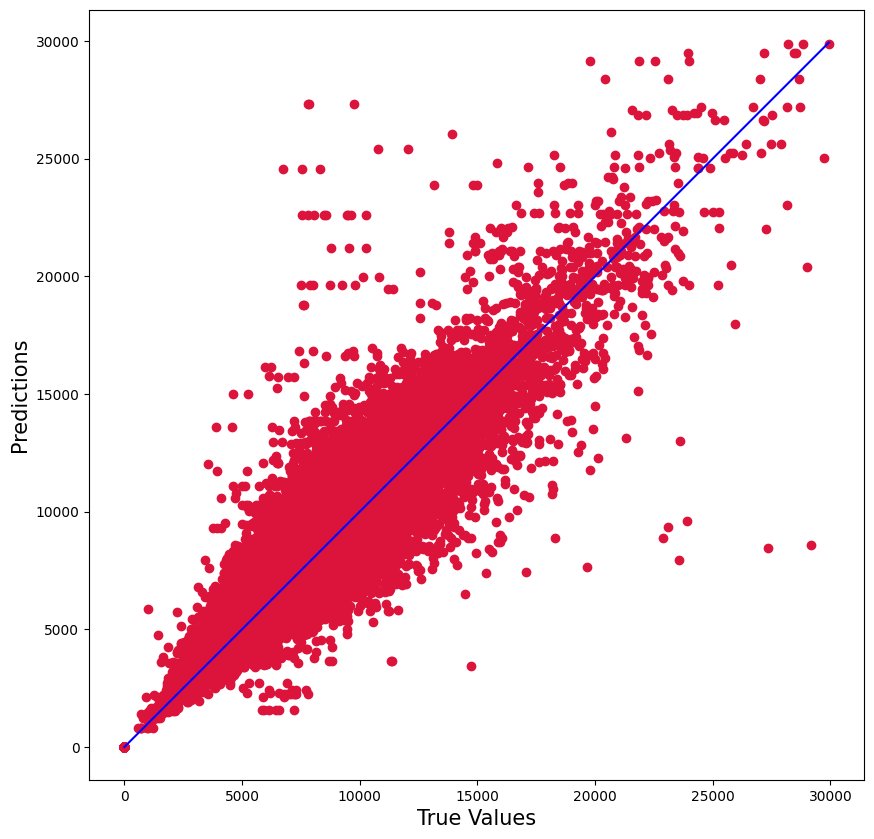

CPU times: user 5.97 s, sys: 96.7 ms, total: 6.06 s
Wall time: 6.03 s


In [61]:
%%time
from sklearn.tree import DecisionTreeRegressor

decision_tree_regressor_model = DecisionTreeRegressor()
decision_tree_regressor_model.fit(x_train,y_train)

prediction_open = decision_tree_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))


print("Test Open Root mean squared error: ", math.sqrt(mean_squared_error(y_test_open,prediction_open)))
print("----------------------------------------------------------")
print("Test Open RMSPE: ", rmspe_score(y_test_open,prediction_open))
print("----------------------------------------------------------")
prediction_train = decision_tree_regressor_model.predict(x_train)
print("Train Root mean squared error: ", math.sqrt(mean_squared_error(y_train,prediction_train)))
print("Train  Root RMSPE: ", rmspe_score(y_train,prediction_train))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))
print("RMSPE: ", rmspe_score(y_test,prediction))


plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Random Forest Regressor had the lowest error as compared to other stores that means it is better at predicting sales than other models so we have selected that as our model

## XGBoost Regressor

In [62]:
import xgboost as xgb
from time import time

def rmspe_score_xg(y_pred: np.ndarray, dtrain: xgb.DMatrix):
    ''' Root mean squared log error metric.'''
    y_true = dtrain.get_label()
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / (y_true))), axis=0))
    return 'rmspe', float(loss)

In [63]:
params = {"objective": "reg:squarederror",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 5000


dtrain = xgb.DMatrix(x_train, y_train.to_numpy())
dvalid = xgb.DMatrix(x_test, y_test_open.to_numpy())
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, custom_metric=rmspe_score_xg, verbose_eval=50)
end = time()
print('Training time is {:2f} s.'.format(end-start))

print("validating")
yhat = gbm.predict(xgb.DMatrix(x_test))
error = rmspe_score(y_test_open, yhat)
print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [08:37:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:3051.67684	train-rmspe:0.62872	eval-rmse:3048.15820	eval-rmspe:0.56129
[50]	train-rmse:2012.95069	train-rmspe:0.41220	eval-rmse:2036.87435	eval-rmspe:0.34938
[100]	train-rmse:1679.07731	train-rmspe:0.34080	eval-rmse:1731.41716	eval-rmspe:0.29665
[150]	train-rmse:1451.42128	train-rmspe:0.29861	eval-rmse:1516.77994	eval-rmspe:0.25693
[200]	train-rmse:1304.28746	train-rmspe:0.27414	eval-rmse:1379.14945	eval-rmspe:0.23201
[250]	train-rmse:1160.63415	train-rmspe:0.24888	eval-rmse:1235.36056	eval-rmspe:0.20423
[300]	train-rmse:1083.70389	train-rmspe:0.23572	eval-rmse:1160.02913	eval-rmspe:0.18923
[350]	train-rmse:1027.30397	train-rmspe:0.22657	eval-rmse:1106.33591	eval-rmspe:0.17740
[400]	train-rmse:990.00198	train-rmspe:0.22031	eval-rmse:1070.90301	eval-rmspe:0.16944
[450]	train-rmse:961.33161	train-rmspe:0.21566	eval-rmse:1045.79058	eval-rmspe:0.16341
[500]	train-rmse:937.52144	train-rmspe:0.21167	eval-rmse:1025.71107	eval-rmspe:0.15871
[550]	train-rmse:918.50891	train-rmspe

In [64]:
error = mean_squared_error(y_test_open, yhat,squared=False)
print('RMSE: {:.6f}'.format(error))

RMSE: 953.504304


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

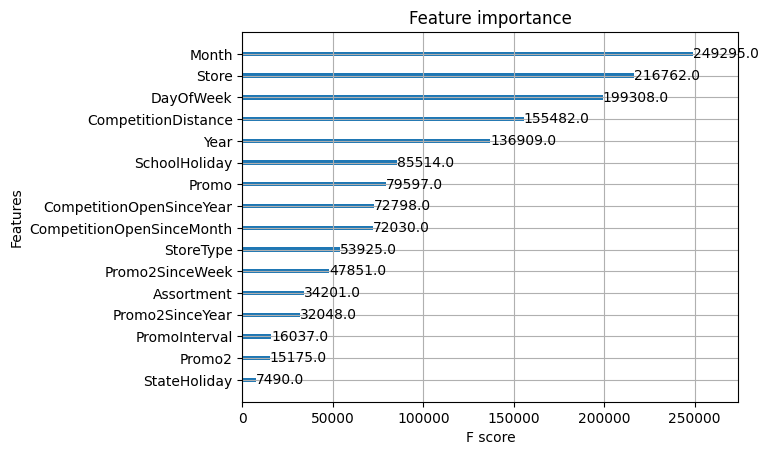

In [65]:
from xgboost import plot_importance
plot_importance(gbm)

## Determine optimal weight

RMSPE for 0.920:0.127003 RMSE:1029.093
RMSPE for 0.921:0.126778 RMSE:1025.786
RMSPE for 0.922:0.126561 RMSE:1022.530
RMSPE for 0.923:0.126352 RMSE:1019.324
RMSPE for 0.924:0.126152 RMSE:1016.169
RMSPE for 0.925:0.125960 RMSE:1013.067
RMSPE for 0.926:0.125776 RMSE:1010.016
RMSPE for 0.927:0.125602 RMSE:1007.018
RMSPE for 0.928:0.125435 RMSE:1004.073
RMSPE for 0.929:0.125277 RMSE:1001.181
RMSPE for 0.930:0.125128 RMSE:998.344
RMSPE for 0.931:0.124987 RMSE:995.561
RMSPE for 0.932:0.124855 RMSE:992.833
RMSPE for 0.933:0.124732 RMSE:990.160
RMSPE for 0.934:0.124617 RMSE:987.544
RMSPE for 0.935:0.124511 RMSE:984.983
RMSPE for 0.936:0.124414 RMSE:982.480
RMSPE for 0.937:0.124326 RMSE:980.033
RMSPE for 0.938:0.124246 RMSE:977.644
RMSPE for 0.939:0.124175 RMSE:975.313
RMSPE for 0.940:0.124113 RMSE:973.041
RMSPE for 0.941:0.124060 RMSE:970.827
RMSPE for 0.942:0.124016 RMSE:968.673
RMSPE for 0.943:0.123980 RMSE:966.578
RMSPE for 0.944:0.123953 RMSE:964.543
RMSPE for 0.945:0.123936 RMSE:962.569
RM

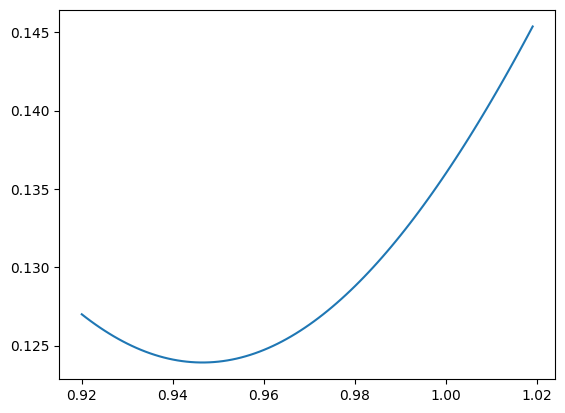

In [66]:
W=[(0.920+(i/1000)) for i in range(100)]
# W=[(0.850+(i/1000)) for i in range(100)]
S =[]
for w in W:
    error = rmspe_score(y_test_open, yhat*w)
    rmse_score = mean_squared_error(y_test_open, yhat*w,squared=False)
    print('RMSPE for {:.3f}:{:.6f} RMSE:{:.3f}'.format(w,error,rmse_score))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
opt_weight = BS.index[0]
opt_score = BS.iloc[0]
print("-----------------------------------------------")
print(f'Best weight :{opt_weight} for Score:{opt_score} ')
print("-----------------------------------------------")

In [67]:
combined_data_subset["Sales"].describe()

count   844185.000000
mean      6951.367608
std       3085.157437
min         46.000000
25%       4859.000000
50%       6368.000000
75%       8358.000000
max      29995.000000
Name: Sales, dtype: float64

## Test Predictions

In [68]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(test)
test_preds = gbm.predict(dtest)

# model1  kaggle private score 0.12647
result = pd.DataFrame({"Id": test_ids, 'Sales': test_preds})
result.to_csv("submission.csv", index=False)

# model2 kaggle private score 0.11756
result = pd.DataFrame({"Id": test_ids, 'Sales': test_preds*opt_weight})
result.to_csv("submission_weighted.csv", index=False)

Make predictions on the test set


In [69]:
check = pd.read_csv("submission.csv")
check.head()

,Id,Sales
0,1,4277.604500
1,2,7878.594000
2,3,9295.021000
3,4,7601.527300
4,5,7782.349600
